In [7]:
#imports para el codigo
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from huffman_code import huffman_code

# Ejercicio 1
Implemente una función en Python que reciba un texto y estime la masa de probabilidad $p(x)$ de aparición de cada carácter presente en el texto. La función debe retornar un diccionario cuya clave sea el caracter y su valor la probabilidad. Genere un gráfico de barras mostrando la frecuencia o probabilidad estimada de cada carácter. Este análisis debe realizarse para tres textos distintos: mitología.txt, tabla.txt y adn.txt, provistos en el campus de la materia.

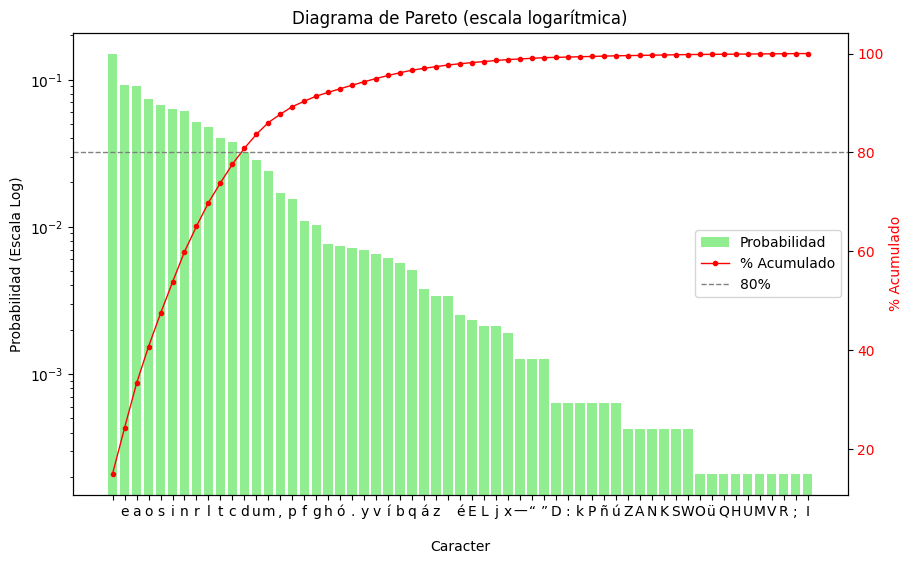

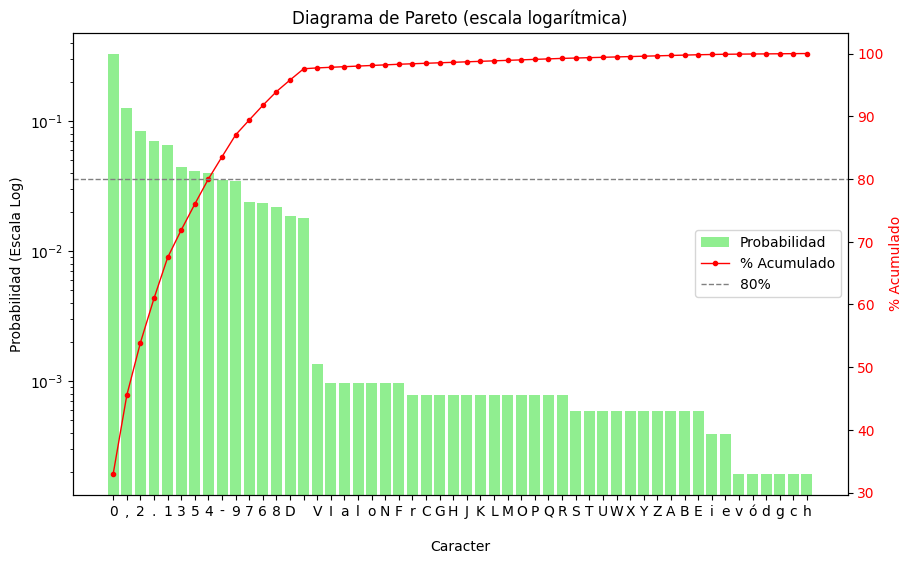

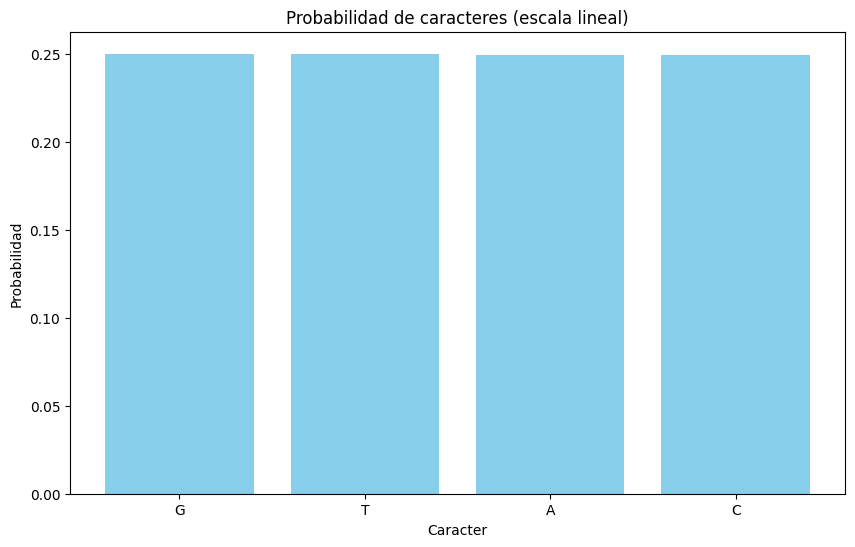

In [8]:
def calcular_probabilidades(texto):
    '''
    Calcula la probabilidad de aparición de cada carácter del texto.
    Devuelve un diccionario {caracter: probabilidad}
    '''
    total = len(texto)
    conteo = {}
    for c in texto:
        conteo[c] = conteo.get(c, 0) + 1
    return {c: f / total for c, f in conteo.items()}

def graficar_probabilidades_y_pareto(dic, titulo):
    '''
    Oredena dic para realizar grafica de caracter-probabilidad en escala lineal
    y si es necesesario (diferencia de proporciones en min y max > 100) 
    suma un esquema de pareto en escala logaritmica
    '''
    # ordenamos el diccionario
    items = list(dic.items())
    items.sort(key=lambda x: x[1], reverse=True)
    
    caracteres = [item[0] for item in items]
    probabilidades = np.array([item[1] for item in items])
    
    # curva de Pareto
    total_suma = np.sum(probabilidades)
    frecuencia_acumulada = np.cumsum(probabilidades)
    acumulados_porcentaje = (frecuencia_acumulada / total_suma) * 100

    # fig es la figura completa; ax1 es el eje izquierdo; ax2 es el eje derecho
    fig, ax = plt.subplots(1, 1, figsize=(10,6))

    
    if np.max(probabilidades)/max(np.min(probabilidades),1e-6) > 100:
        # ahora graficamos en escala log para comparar con mayor resolucion (grandes diferencias en barras lineales)
        ax.bar(caracteres, probabilidades, color='lightgreen', label='Probabilidad')
        ax.set_title('Diagrama de Pareto (escala logarítmica)')
        ax.set_xlabel('Caracter')
        ax.set_ylabel('Probabilidad (Escala Log)')
        ax.set_yscale('log') 

        # sumamos la curva de Pareto para la cumulativa
        ax2_pareto = ax.twinx() # crea el segundo eje Y en el panel derecho
        ax2_pareto.plot(caracteres, acumulados_porcentaje, color='red', marker='.', linestyle='-', linewidth=1, label='% Acumulado')
        ax2_pareto.set_ylabel('% Acumulado', color='red')
        ax2_pareto.tick_params(axis='y', labelcolor='red')

        # referencia del 80%
        ax2_pareto.axhline(80, color='gray', linestyle='--', linewidth=1, label='80%')
        
        # Leyenda combinada para el gráfico de Pareto
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2_pareto.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='center right')
    else:
        # graficamos las probabilidades (escala lineal)
        ax.bar(caracteres, probabilidades, color='skyblue', label='Proabilidad')
        ax.set_title('Probabilidad de caracteres (escala lineal)')
        ax.set_xlabel('Caracter')
        ax.set_ylabel('Probabilidad')
    
    
    #plt.savefig(f'grafico_{titulo}.pdf', format='pdf', bbox_inches='tight') # para guardar los graficos
    plt.show()

textos = {
    "Mitología": "textos/mitología.txt",
    "Tabla": "textos/tabla.txt",
    "ADN": "textos/adn.txt"
}

probabilidades = {}

for nombre, path in textos.items():
      with open(path, "r", encoding="utf-8") as f:
          texto = f.read()

      p = calcular_probabilidades(texto)
      probabilidades[nombre] = p
      # Genera y muestra el gráfico de distribución de probabilidades
      graficar_probabilidades_y_pareto(p, nombre)

# Ejercicio 2

Utilice la función *huffman\_code()* provista por la cátedra para la codificación de Huffman, la cual recibe el diccionario de probabilidades (generado en el Ejercicio 1) y retorna un diccionario con el código de Huffman para cada carácter.

Genere la secuencia de bits codificada para cada texto provisto, y calcule y compare:

- La longitud promedio de bits (sin redondear) para la codificación no uniforme: $L = \sum_{i=1}^{N} p(x_i) \, l(x_i)$
  
  donde $N$ es la cantidad de símbolos diferentes en el texto,
  $x_i$ el i-ésimo símbolo, y $l(x_i)$ la longitud (en bits)
  asignada por el código de Huffman a ese símbolo.

- La cantidad de bits (enteros) mínima para representar los $N$ símbolos
  del texto con una codificación uniforme (misma cantidad de bits para todos
  los símbolos presentes).

- El porcentaje de memoria reducido con Huffman respecto de la codificación uniforme.


In [9]:
def analizar_codificacion(probabilidades):
    '''
    Calcula la longitud promedio L, la longitud uniforme L_uniforme y
    el ahorro porcentual respecto a la codificación uniforme.
    Utiliza la función huffman_code() provista por la cátedra.
    '''
    codigos = huffman_code(probabilidades)
    L = sum(probabilidades[c] * len(codigos[c]) for c in probabilidades)
    N = len(probabilidades)
    L_uniforme = math.ceil(math.log2(N))
    ahorro = (1 - L / L_uniforme) * 100
    return codigos, L, L_uniforme, ahorro

resultados_codificacion = {}

for nombre, p in probabilidades.items():
    codigos, L, L_uniforme, ahorro = analizar_codificacion(p)
    resultados_codificacion[nombre] = {
        "L promedio": L,
        "L uniforme": L_uniforme,
        "Ahorro (%)": ahorro
    }

pd.DataFrame(resultados_codificacion).T

,L promedio,L uniforme,Ahorro (%)
Mitología,4.366182,6.0,27.230294
Tabla,3.530120,6.0,41.164659
ADN,2.000000,2.0,0.000000


# Ejercicio 3
 Calcule la entropía $H(X)$ de cada texto a partir de las probabilidades estimadas y compárela con la longitud promedio de codificación. Discuta qué tan cercanas son ambas magnitudes y qué representan. Extraiga conclusiones.

In [10]:
def calcular_entropia(probabilidades):
    # Calcula la entropía H(X) = -∑ p(x) log2(p(x))
    return -sum(p * math.log2(p) for p in probabilidades.values())

resultados_entropia = {}

for nombre, p in probabilidades.items():
    H = calcular_entropia(p)
    L = resultados_codificacion[nombre]["L promedio"]
    resultados_entropia[nombre] = {
        "Entropía H(X)": H,
        "L promedio": L,
        "Diferencia (L - H)": L - H
    }

pd.DataFrame(resultados_entropia).T

,Entropía H(X),L promedio,Diferencia (L - H)
Mitología,4.332977,4.366182,3.320556e-02
Tabla,3.480857,3.530120,4.926372e-02
ADN,1.999999,2.000000,8.077575e-07


# Ejercicio 4
 Para comparar las entropías entre los distintos textos, debido a que cada uno posee una cantidad $N$ de símbolos distinta, utilizaremos la entropía normalizada $η = H(X)/log2(N)$. Compare las entropías normalizadas entre los tres textos provistos y discuta los resultados teniendo presente las características de cada archivo y probabilidades de símbolos respectivos.

In [12]:
def entropia_normalizada(H, N):
    # Calcula la entropía normalizada η = H(X) / log2(N)
    return H / math.log2(N)

resultados_norm = {}

for nombre, p in probabilidades.items():
    H = calcular_entropia(p)
    N = len(p)
    eta = entropia_normalizada(H, N)
    resultados_norm[nombre] = {"η": eta}

df_final = pd.concat([
    pd.DataFrame(resultados_codificacion).T,
    pd.DataFrame(resultados_entropia).T.drop(columns=["L promedio"]),
    pd.DataFrame(resultados_norm).T
], axis=1)

df_final


,L promedio,L uniforme,Ahorro (%),Entropía H(X),Diferencia (L - H),η
Mitología,4.366182,6.0,27.230294,4.332977,3.320556e-02,0.73657
Tabla,3.530120,6.0,41.164659,3.480857,4.926372e-02,0.61063
ADN,2.000000,2.0,0.000000,1.999999,8.077575e-07,1.00000
